# Training on 25,000 events. Testing on the RAMP set.

In [1]:
!nvidia-smi

Wed Sep  6 14:25:12 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 35%   54C    P2    49W / 180W |   1798MiB /  8114MiB |     93%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   30C    P8     9W / 180W |      2MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
import sys
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0C:00.0)


### Load in the data.

In [3]:
%%time
modelpath   = "data/models/UNIF-10N-25T-25000E-235R.h5"
trainpath   = "data/sets/UNIF-10N-25T-25000E-235R.gz"
testpath    = "data/sets/RAMP-10N-25T-3600E-235R.gz"
train_frame = pd.read_csv(trainpath)
test_frame  = pd.read_csv(testpath)
train       = utils.list_of_groups(train_frame, group="event_id")
test        = utils.list_of_groups(test_frame,  group="event_id")
print("Train is list of {0} events ({1} bytes).".format(len(train), sys.getsizeof(train)))
print("Test is list of {0} events ({1} bytes).".format(len(test), sys.getsizeof(test)))
if (not utils.is_prepared(train_frame)) or (not utils.is_prepared(test_frame)):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")
else:
    del train_frame
    del test_frame # To save on memory space.

Train is list of 25000 events (200320 bytes).
Test is list of 3600 events (30120 bytes).
CPU times: user 10.3 s, sys: 316 ms, total: 10.6 s
Wall time: 10.6 s


In [4]:
order = ["phi", "r", "z"]

### Show an example of the data.

Train 8881
Number of Hits: 87
Number of Tracks: 9


<IPython.core.display.Javascript object>


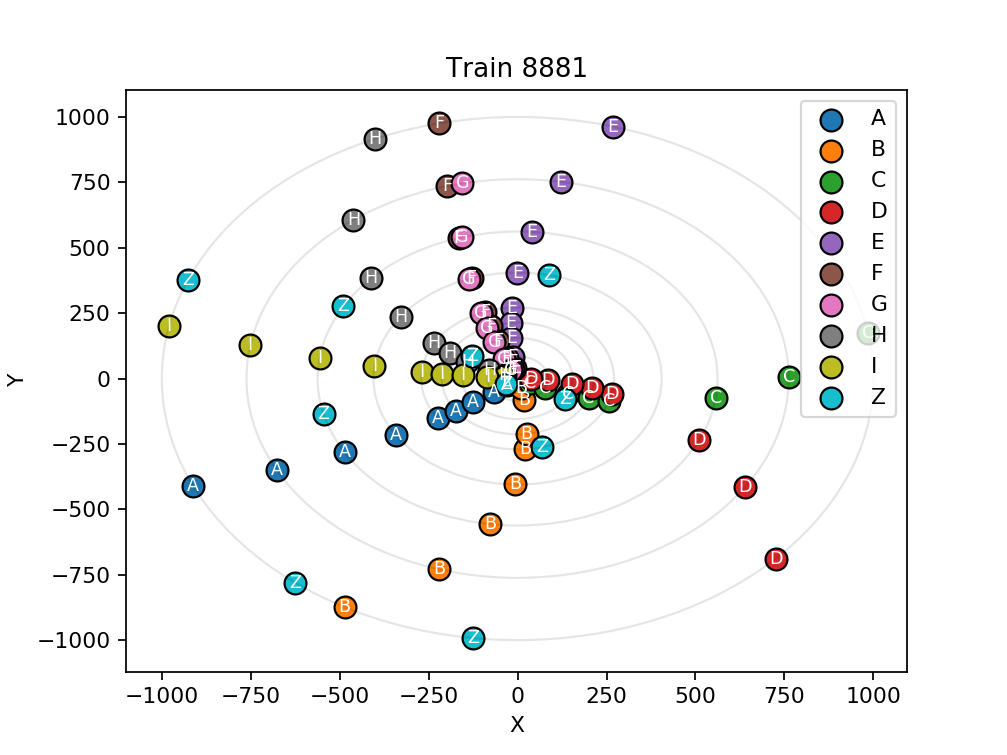

In [5]:
n = 8881 #np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [6]:
print(n)
visuals.display(train[n], order)

8881


,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-2.895529,562.0,-80.662152,,,,,,,,,,,,,,,,,,,,,,,,,,1,
1,-2.719777,1000.0,-48.289718,1,,,,,,,,,,,,,,,,,,,,,,,,,,
2,-2.663688,762.0,-36.796765,1,,,,,,,,,,,,,,,,,,,,,,,,,,
3,-2.615846,562.0,-27.138822,1,,,,,,,,,,,,,,,,,,,,,,,,,,
4,-2.577248,405.0,-19.557336,1,,,,,,,,,,,,,,,,,,,,,,,,,,
5,-2.546779,39.0,117.754959,,,,,,,,,,,,,,,,,,,,,,,,,,1,
6,-2.543667,271.0,-13.086514,1,,,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.527406,213.0,-10.285710,1,,,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.509782,155.0,-7.484906,1,,,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.485555,85.0,-4.104626,1,,,,,,,,,,,,,,,,,,,,,,,,,,


### Create the model.

In [7]:
input_shape  = (235, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [10]:
# If you have already created a model, run this cell to load the model.
# Else, just run the cell below this cell.
model = keras.models.load_model(modelpath)

In [8]:
model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 235, 256)          399360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 235, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 235, 256)          787968    
_________________________________________________________________
dropout_2 (Dropout)          (None, 235, 256)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 235, 256)          787968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 235, 256)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 235, 27)           6939      
Total para

### Fit the model.

In [9]:
%%time
# Current model has been trained on 68 epochs before early stopping.
epochs     = 128
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.EarlyStopping(patience=5, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)]))

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Epoch 1/128
250/250 [==============================] - 370s - loss: 1.3019 - acc: 0.6062 - val_loss: 0.5993 - val_acc: 0.7548
Epoch 2/128
250/250 [==============================] - 356s - loss: 0.9113 - acc: 0.6635 - val_loss: 0.6208 - val_acc: 0.7534
Epoch 3/128
250/250 [==============================] - 353s - loss: 0.8253 - acc: 0.6914 - val_loss: 0.5371 - val_acc: 0.7893
Epoch 4/128
250/250 [==============================] - 355s - loss: 0.7736 - acc: 0.7089 - val_loss: 0.4188 - val_acc: 0.8404
Epoch 5/128
250/250 [==============================] - 355s - loss: 0.7339 - acc: 0.7235 - val_loss: 0.3773 - val_acc: 0.8695
Epoch 6/128
250/250 [==============================] - 354s - loss: 0.7012 - acc: 0.7375 - val_loss: 0.3554 - val_acc: 0.8799
Epoch 7/128
250/250 [==============================] - 354s - loss: 0.6742 - acc: 0.7503 - val_loss: 0.3346 - val_acc: 0.8864
Epoch 8/128
250/250 [==============================] - 354s - loss: 0.6519 - acc: 0.7598 - val_loss: 0.3807 - val_acc:

### Display information about the model after fitting it.

In [11]:
%%time
test.sort(key=lambda x: x.iloc[0]["event_id"])
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 84.46742415845618%
Percent of tracks assigned correctly: 59.6166053065888%
Percent of events with the correct number of tracks: 83.27777777777777%
CPU times: user 1min 32s, sys: 116 ms, total: 1min 32s
Wall time: 1min 32s


In [10]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

There are 1000 events with 1 tracks.
There are 1000 events with 2 tracks.
There are 1000 events with 3 tracks.
There are 1000 events with 4 tracks.
There are 1000 events with 5 tracks.
There are 1000 events with 6 tracks.
There are 1000 events with 7 tracks.
There are 1000 events with 8 tracks.
There are 1000 events with 9 tracks.
There are 1000 events with 10 tracks.
There are 1000 events with 11 tracks.
There are 1000 events with 12 tracks.
There are 1000 events with 13 tracks.
There are 1000 events with 14 tracks.
There are 1000 events with 15 tracks.
There are 1000 events with 16 tracks.
There are 1000 events with 17 tracks.
There are 1000 events with 18 tracks.
There are 1000 events with 19 tracks.
There are 1000 events with 20 tracks.
There are 1000 events with 21 tracks.
There are 1000 events with 22 tracks.
There are 1000 events with 23 tracks.
There are 1000 events with 24 tracks.
There are 1000 events with 25 tracks.


### Display how one of the model's predictions looks.

Percent of hits assigned correctly: 94.73684210526315%
Percent of tracks assigned correctly: 69.23076923076923%


<IPython.core.display.Javascript object>


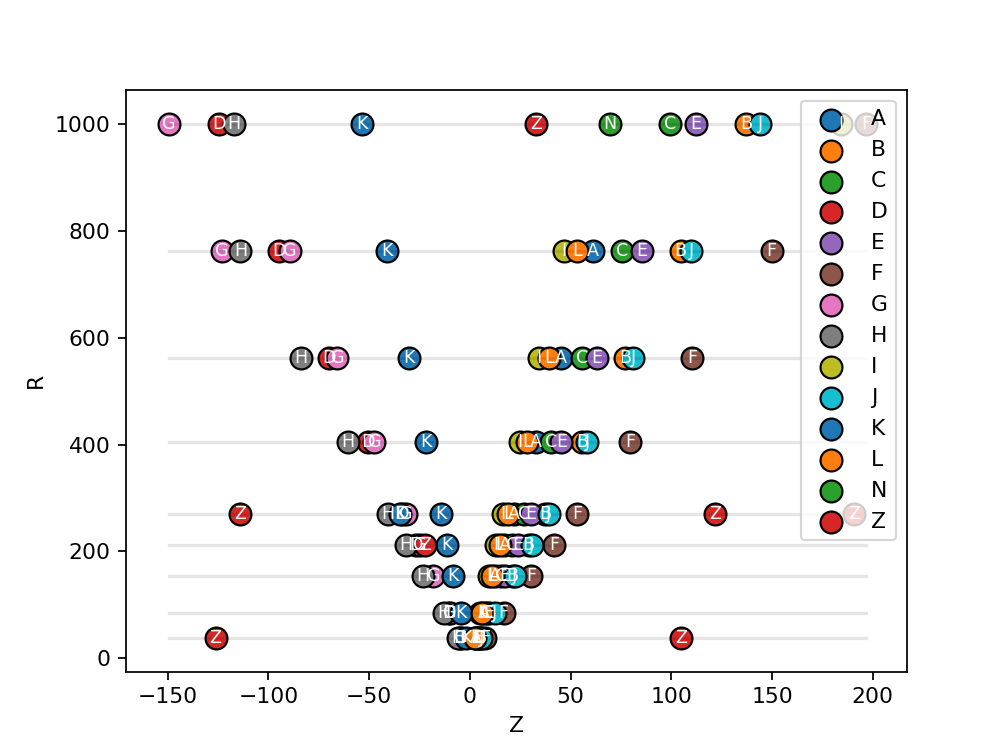

<IPython.core.display.Javascript object>


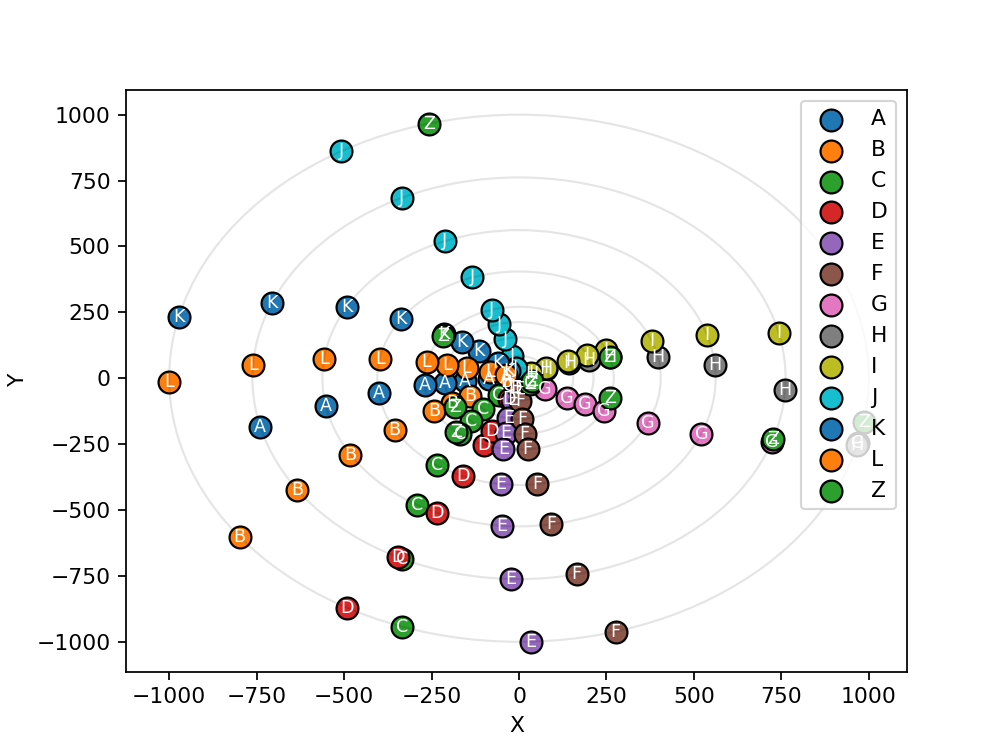

In [16]:
n = 300
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr")
_ = visuals.Plot2D(test[n], order).plot(mode="xy")

In [12]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-3.135183,39.0,3.136430,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
1,-3.128793,1000.0,69.598063,,,,,,,,,,,,`1`[0],,`0`[1],,,,,,,,,,,,,
2,-3.106740,85.0,6.835809,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
3,-3.079980,155.0,12.465299,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
4,-3.060783,213.0,17.129733,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
5,-3.041685,271.0,21.794168,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
6,-3.000976,405.0,32.570619,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.954940,562.0,45.196761,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.897302,762.0,61.281017,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.739038,39.0,5.354824,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,


### Display the graphs.

<IPython.core.display.Javascript object>


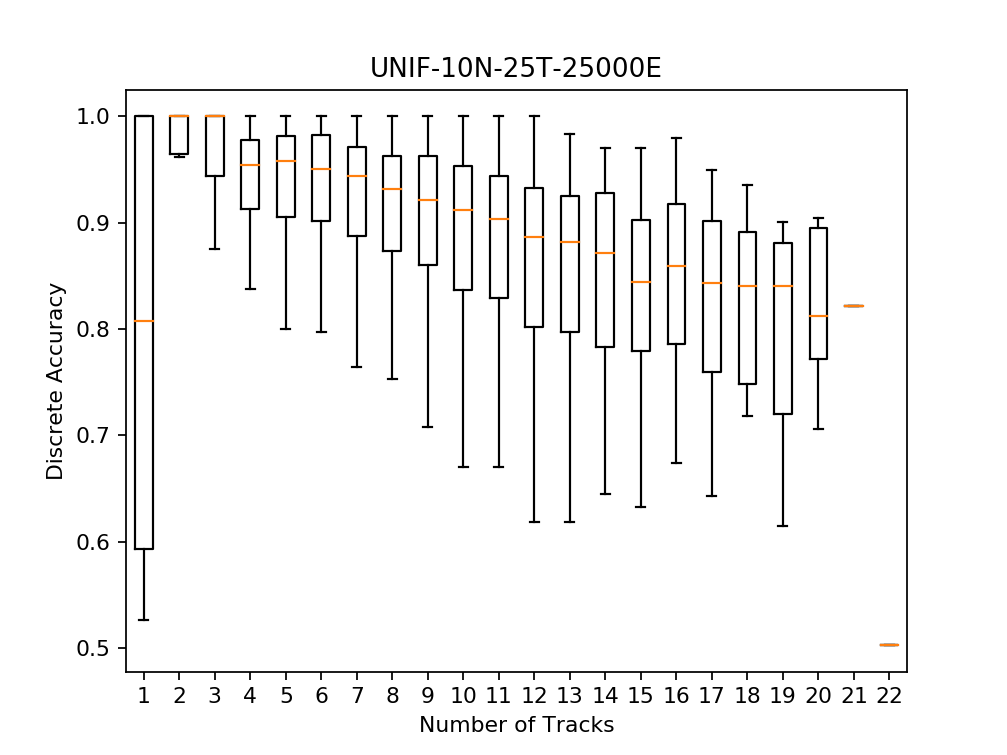

CPU times: user 28.8 s, sys: 4 ms, total: 28.8 s
Wall time: 28.8 s


In [12]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "UNIF-10N-25T-25000E", "Number of Tracks", "Discrete Accuracy", xticks=list(r))

### Track metric plots.

<IPython.core.display.Javascript object>


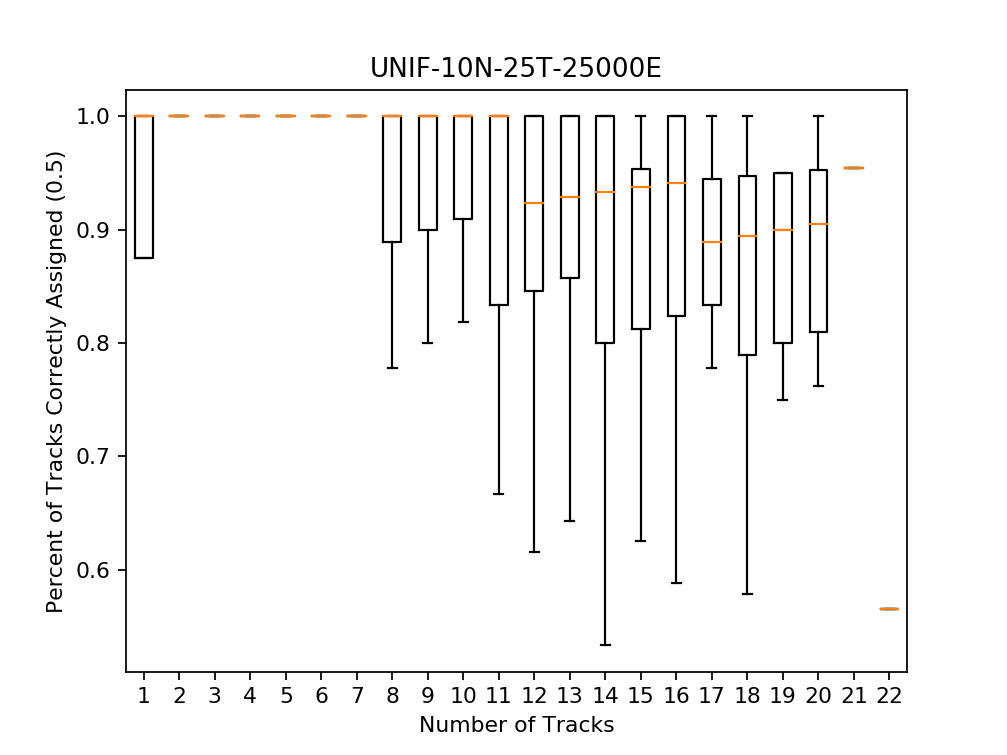

<IPython.core.display.Javascript object>


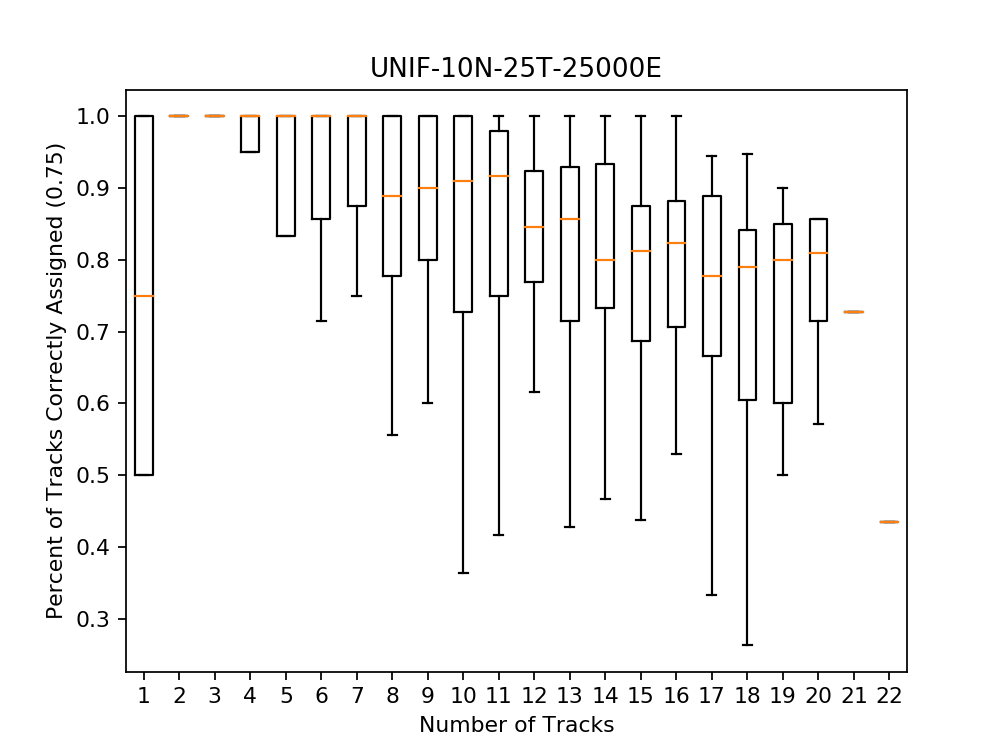

<IPython.core.display.Javascript object>


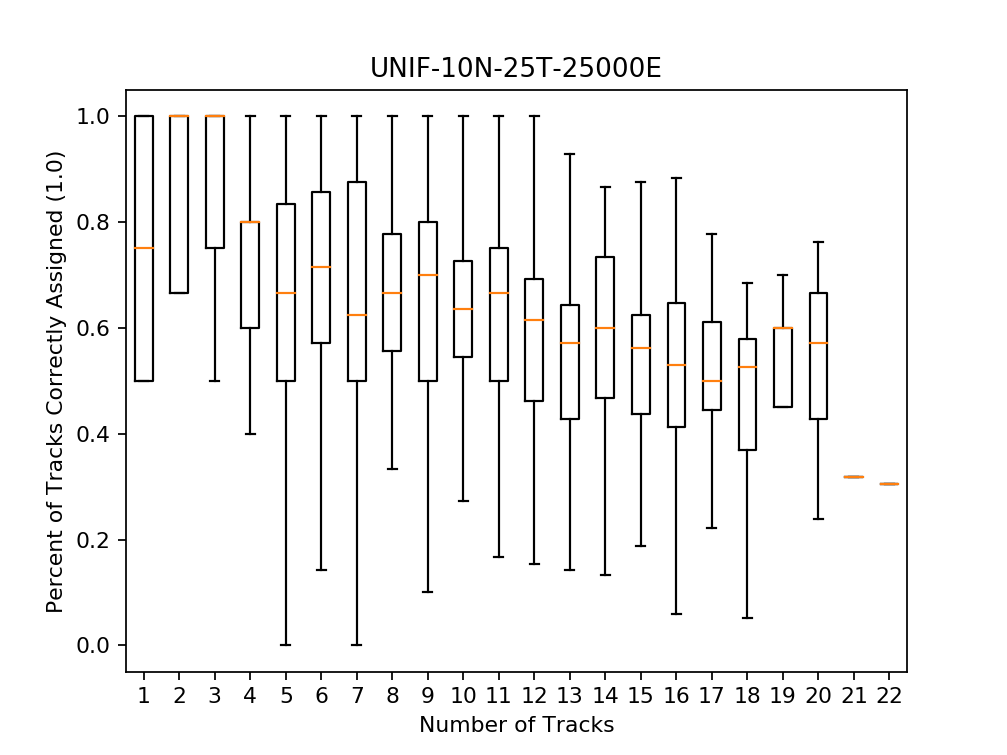

CPU times: user 1min 54s, sys: 32 ms, total: 1min 54s
Wall time: 1min 54s


In [13]:
%%time
for percent in [0.5, 0.75, 1.0]:
    c_tracks = [metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order, percent=percent)
                for n in range(len(guesses))]
    boxes = [[] for _ in r]
    for i in range(len(c_tracks)):
        index = metrics.number_of_tracks(test[i]) - 1
        boxes[index].append(c_tracks[i])
    visuals.boxplot(
        boxes, "UNIF-10N-25T-25000E", "Number of Tracks",
        "Percent of Tracks Correctly Assigned ({})".format(percent), xticks=list(r))

### Threshold plots.

<IPython.core.display.Javascript object>


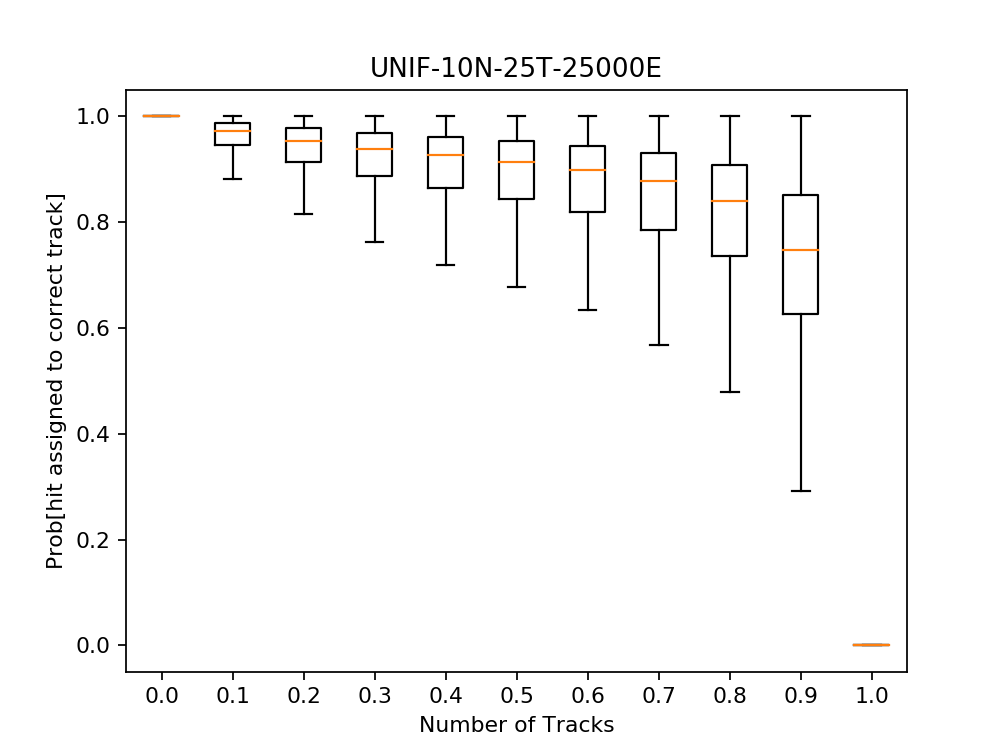

<IPython.core.display.Javascript object>


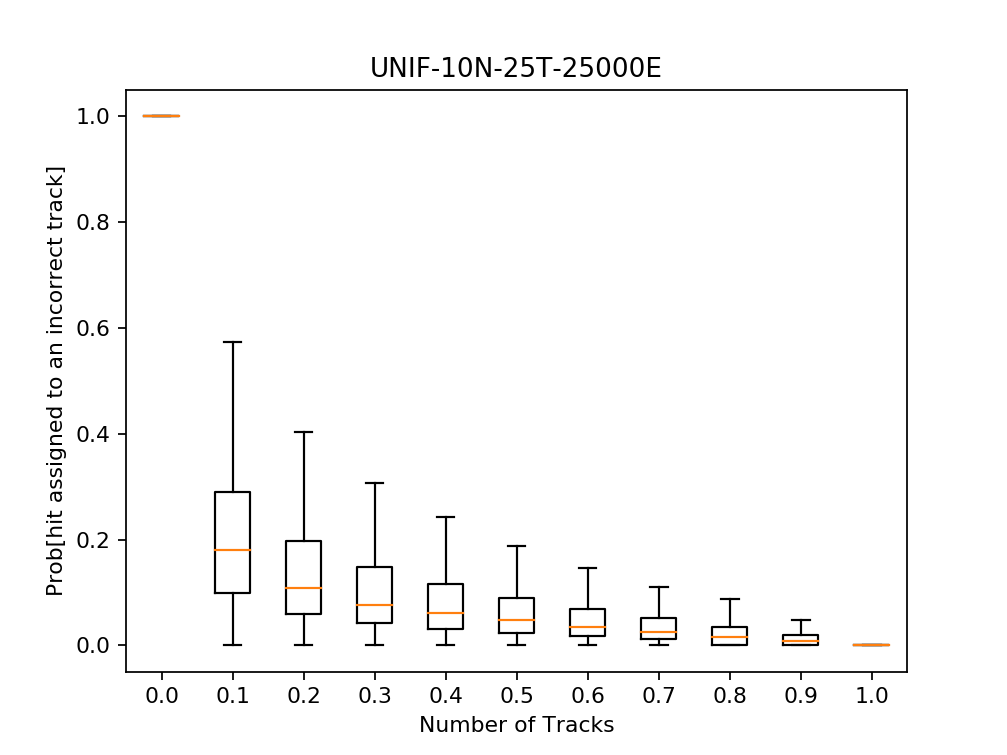

<IPython.core.display.Javascript object>


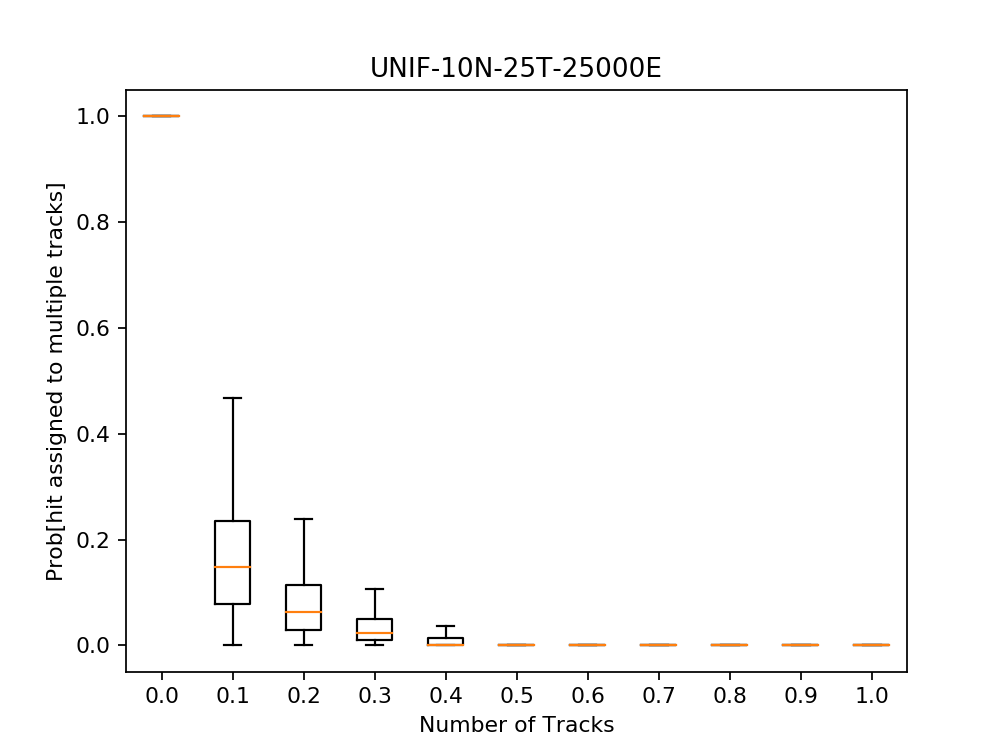

<IPython.core.display.Javascript object>


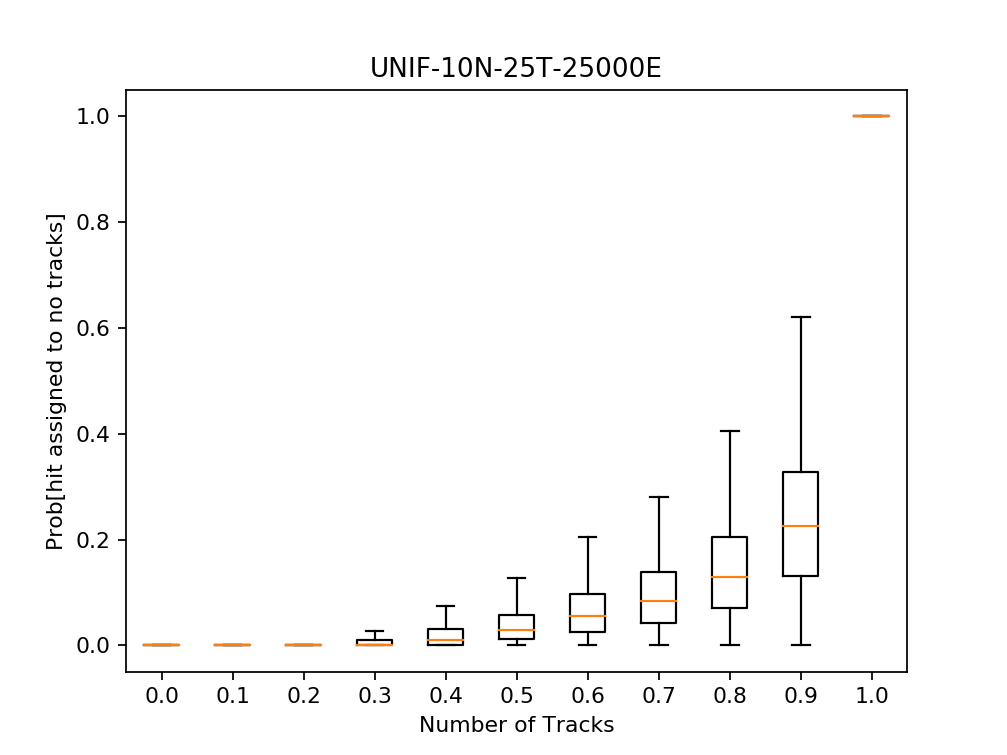

CPU times: user 4min 17s, sys: 44 ms, total: 4min 18s
Wall time: 4min 18s


In [19]:
%%time
thresholds = [i / 10 for i in range(11)]
threshold_metrics = [[metrics.threshold_metrics(test[i], guesses[i], n, order)
                      for i in range(len(guesses))] for n in thresholds]
boxes_correct   = [[m[0] for m in metric] for metric in threshold_metrics]
boxes_incorrect = [[m[1] for m in metric] for metric in threshold_metrics]
boxes_multi     = [[m[2] for m in metric] for metric in threshold_metrics]
boxes_none      = [[m[3] for m in metric] for metric in threshold_metrics]
visuals.boxplot(
    boxes_correct, 
    "UNIF-10N-25T-25000E", "Number of Tracks", "Prob[hit assigned to correct track]", xticks=thresholds)
visuals.boxplot(
    boxes_incorrect, 
    "UNIF-10N-25T-25000E", "Number of Tracks", "Prob[hit assigned to an incorrect track]", xticks=thresholds)
visuals.boxplot(
    boxes_multi, 
    "UNIF-10N-25T-25000E", "Number of Tracks", "Prob[hit assigned to multiple tracks]", xticks=thresholds)
visuals.boxplot(
    boxes_none, 
    "UNIF-10N-25T-25000E", "Number of Tracks", "Prob[hit assigned to no tracks]", xticks=thresholds)